In [16]:
pip install -r ../services/ml_training/requirements.txt

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
     ---------------------------------------- 0.0/642.7 kB ? eta -:--:--
     ---- ---------------------------------- 81.9/642.7 kB 2.3 MB/s eta 0:00:01
     ------------- ------------------------ 235.5/642.7 kB 3.6 MB/s eta 0:00:01
     ----------------------- -------------- 399.4/642.7 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 642.7/642.7 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
     ---------------------------------------- 0.0/42.9 kB ? eta

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Celda 1: Instalación de Dependencias (Con el comando mágico %)
# Forzamos una versión de matplotlib estable y D-Tale
%pip install pandas numpy seaborn matplotlib==3.7.3 sqlalchemy psycopg2-binary dtale

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------------------------- ------------ 41.0/61.0 kB 487.6 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 651.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.5 MB 2.6 MB/s eta 0:00:03
   - -------------------------------------- 0.3/7.5 MB 3.5 MB/s eta 0:00:03
   --- ------------------------------------ 0.7/7.5 MB 5.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.5 MB 7.2 MB/s eta 0:00:01
   ----- ---------------------------------- 1.0/7.5 MB 5.5 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.5 MB 5.5 MB/s eta 0:00:02
   -------- ------------------------------- 1.6/7.5 MB 5.5 MB/s eta 0:00:02
   ----------- -------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## **🟢 PARTE 1: ANÁLISIS MACRO**
Objetivo: Entender el terreno de juego global antes de mirar a los jugadores. Validar la calidad del dato y definir el contexto. Para ello se realizarán los siguiente cálculos:

### 1. Auditoría de Integridad (Data Health)
    - Mapa de Calor de Nulos
    - Cardinalidad de Variables
    - Detección de Duplicados Ocultos
### 2. La "Frontera de la Relevancia" (Análisis de Volumen)
    - Histograma de Minutos Jugados + Curva de Densidad
    - Distribución de Edad
    - Pareto del Juego
### 3. Distribución Estadística Global (Univariada)
    - Test de Normalidad (Shapiro-Wilk) en métricas clave
    - Skewness (Asimetría) y Kurtosis

In [ ]:
# Carga de Librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # poner en requirements.txt si se usa


In [64]:


# Configuración Visual Profesional
plt.style.use('ggplot') #nuevo
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', None) # Para ver todas las columnas en los describe()

# ==============================================================================
# 0. CARGA DE DATOS (Input del ETL)
# ==============================================================================
INPUT_FILE = '../services/ingestion/data_drop/fbref_big5_players_24_25_clean.csv'

try:
    df = pd.read_csv(INPUT_FILE)
    print(f"✅ BASE CARGADA: {df.shape[0]} registros | {df.shape[1]} variables")
except FileNotFoundError:
    # Fallback local
    df = pd.read_csv('fbref_big5_players_24_25_clean.csv')
    print(f"✅ BASE CARGADA (LOCAL): {df.shape[0]} registros")

df.head(101)



✅ BASE CARGADA: 3006 registros | 151 variables


,player_name,nation,main_position_group,squad,league_id,age,record_type,rank,born,matches_played,starts,minutes_played,nineties,goals,assists,goals_assists,non_penalty_goals,pk_goals,pk_attempts,yellow_cards,red_cards,xg,npxg,xag,npxg_plus_xa,progressive_carries,progressive_passes,progressive_runs,non_penalty_goals_assists,expected_goals_assists,shots_total,shots_on_target,shots_on_target_pct,shots_p90,shots_on_target_p90,goals_per_shot,goals_per_sot,avg_shot_distance,free_kick_shots,npxg_per_shot,goals_minus_xg,np_goals_minus_npxg,passes_completed,passes_attempted,pass_completion_pct,pass_total_distance,pass_progressive_distance,xa,assists_minus_xa,key_passes,passes_final_third,passes_penalty_area,crosses_penalty_area,passes_live,passes_dead,passes_through_balls,passes_switches,passes_crosses,passes_throw_ins,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,offsides,blocks,sca,sca_p90,sca_pass_live,sca_pass_dead,sca_dribble,fouls_drawn,sca_defense,gca,gca_p90,tackles_total,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,challenge_tackles_pct,challenges_lost,blocks_passes,interceptions,tackles_interceptions,clearances,errors_leading_to_goal,touches,touches_def_pen_area,touches_att_pen_area,dribbles_completed,dribble_success_pct,dribbles_tackled,dribbles_tackled_pct,carries,carries_penalty_area,miscontrols,dispossessed,passes_received,minutes_per_match,minutes_pct,minutes_per_start,matches_completed,matches_subbed_in,minutes_per_sub,unused_sub,points_per_match,on_goals_for,on_goals_against,plus_minus,plus_minus_p90,plus_minus_on_off,on_xg_for,on_xg_against,xg_plus_minus,xg_plus_minus_p90,second_yellow_card,fouls_committed,pk_won,pk_conceded,own_goals,ball_recoveries,aerials_won,aerials_won_pct,goals_against,goals_against_p90,shots_on_target_against,saves,save_pct,wins,draws,losses,clean_sheets,clean_sheet_pct,pk_allowed,pk_saved,pk_missed,psxg,psxg_per_sot,psxg_plus_minus,unknown_p90,gk_passes_attempted_launch,gk_throws,launch_pct,avg_pass_length,gk_crosses_faced,crosses_stopped,crosses_stopped_pct,def_actions_outside_box,def_actions_outside_box_p90,avg_keeper_sweeper_dist,team_order
0,Max Aarons,ENG,DF,Bournemouth,Premier League,24.0,Parcial,1,2000.0,3,1,86,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,8,3,0.00,0.00,0,0,0.0,0.00,0.00,0.0,0.0,0.0,0,0.00,0.0,0.0,50,63,79.4,887,361,0.0,0.0,0,8,0,0,51,12,0,0,2,10,0,0,0,0,0,1,2,2.09,2,0,0,0,0,0,0.00,2,2,1,1,0,100.0,0,2,1,3,0,0,73,2,0,0,0.0,1,50.0,41,0,1,0,40,29.0,2.5,61.0,0,2,13.0,11,0.67,2,0,2,2.09,1.82,2.3,0.3,2.0,2.12,0,0,0,0,0,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Max Aarons,ENG,DF,Valencia,La Liga,24.0,Parcial,2,2000.0,4,1,120,1.3,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0,6,10,0.00,0.02,0,0,0.0,0.00,0.00,0.0,0.0,0.0,0,0.00,0.0,0.0,47,66,71.2,705,190,0.0,0.0,1,2,0,0,54,12,0,0,5,11,0,0,0,0,0,1,1,0.75,1,0,0,0,0,0,0.00,4,4,2,2,0,80.0,1,1,0,4,3,0,85,1,0,1,25.0,2,50.0,46,0,3,1,49,30.0,3.5,73.0,0,3,16.0,14,0.75,1,3,-2,-1.50,-1.28,1.5,3.7,-2.3,-1.69,0,0,0,0,0,7,2,66.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Rodrigo Abajas,ESP,DF,Valencia,La Liga,21.0,Parcial,3,2003.0,1,1,65,0.7,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,2,3,0.00,0.10,1,0,0.0,1.38,0.00,0.0,0.0,24.5,0,0.07,-0.1,-0.1,17,29,58.6,268,110,0.0,0.0,0,0,0,0,21,8,0,0,1,8,0,0,0,0,0,2,0,0.00,0,0,0,0,0,0,0.00,3,2,2,1,0,100.0,0,1,1,4,0,0,36,1,1,1,100.0,0,0.0,13,1,0,2,16,65.0,1.9,65.0,0,0,0.0,8,0.00,1,2,-1,-1.38,-1.14,1.4,0.7,0.7,0.93,0,2,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,James Abankwah,IRL,DF,Udinese,Serie A,20.0,Parcial,4,2004.0,6,0,88,1.0,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,4,1,0.00,0.06,1,0,0.0,1.02,0.00,0.0,0.0,15.0,0,0.06,-0.1,-0.1,36,46,78.3,614,206,0.0,0.0,0,2,0,0,45,1,0,0,0,0,0,0,0,0,0,0,1,1.02,1,0,0,0,0,0,0.00,4,2,4,0,0,66.7,1,1,1,5,3,0,65,8,2,0,0.0,0,0.0,29,1,1,3,34,15.0,2.6,0

In [48]:
# ==============================================================================
# PARTE 1: ANÁLISIS DE INTEGRIDAD Y ESTRUCTURAL DE LOS DATOS
# ==============================================================================
print("\n" + "="*50)
print("1. VISIÓN GENERAL (HEALTH CHECK)")
print("="*50)

# A. Integridad de la Base (Nulos)

def elite_audit(df):
    """
    Genera un reporte de salud básico del dataframe.
    """
    # 1. Tipos de datos
    audit = pd.DataFrame(df.dtypes, columns=['Dtype'])
    
    # 2. Conteo de nulos y porcentaje
    audit['Nulos'] = df.isnull().sum()
    audit['% Nulos'] = (df.isnull().sum() / len(df)) * 100
    
    # 3. Valores únicos (Cardinalidad)
    audit['Unicos'] = df.nunique()
    
    # 4. Memoria (opcional, bueno para Big Data)
    audit['Memoria_KB'] = df.memory_usage(deep=True) // 1024
    
    
    return audit.sort_values(by='% Nulos', ascending=False)



# Ejecución de la auditoría

reporte = elite_audit(df)
display(reporte)






1. VISIÓN GENERAL (HEALTH CHECK)


,Dtype,Nulos,% Nulos,Unicos,Memoria_KB
save_pct,float64,152,5.056554,122,23
challenge_tackles_pct,float64,152,5.056554,367,23
pass_completion_pct,float64,152,5.056554,416,23
minutes_per_sub,float64,152,5.056554,62,23
shots_on_target_p90,float64,152,5.056554,211,23
...,...,...,...,...,...
xa.13,float64,0,0.000000,98,23
xa.14,float64,0,0.000000,100,23
xa.15,float64,0,0.000000,98,23
assists_minus_xa,float64,0,0.000000,99,23


In [49]:
# Cómo anteriormente vomos que hay nulos en columnas float, visualizamos los nulos

nulos_float = reporte[(reporte['% Nulos'] > 0) & (reporte['Dtype'] == 'float64')]
nulos_float


,Dtype,Nulos,% Nulos,Unicos,Memoria_KB
save_pct,float64,152,5.056554,122,23
challenge_tackles_pct,float64,152,5.056554,367,23
pass_completion_pct,float64,152,5.056554,416,23
minutes_per_sub,float64,152,5.056554,62,23
shots_on_target_p90,float64,152,5.056554,211,23
shots_p90,float64,152,5.056554,430,23
shots_on_target_pct,float64,152,5.056554,278,23
minutes_per_start,float64,152,5.056554,52,23
minutes_pct,float64,152,5.056554,874,23
minutes_per_match,float64,152,5.056554,90,23


In [56]:
# Quiero ver ahora si es que los valores nulos de las columnas que presentan valores NaN en columnas float, se concentran en algún "squad" específico, por ejemplo "COMBINADAS"
nulos_float_squads = df[df[nulos_float.index].isnull().any(axis=1)]['squad'].value_counts()
display(nulos_float_squads)

# Dame un ejemplo de la tabla para corroborar
df[df[nulos_float.index].isnull().any(axis=1)].head(10)

squad
COMBINED    152
Name: count, dtype: int64

,player_name,nation,main_position_group,squad,league_id,age,record_type,rank,born,matches_played,starts,minutes_played,nineties,goals,assists,goals_assists,non_penalty_goals,pk_goals,pk_attempts,yellow_cards,red_cards,xg,npxg,xa,xa.1,xa.2,xa.3,xa.4,xa.5,xa.6,xa.7,npxg_plus_xa,progressive_carries,progressive_passes,progressive_runs,non_penalty_goals_assists,expected_goals_assists,shots_total,shots_on_target,shots_on_target_pct,shots_p90,shots_on_target_p90,goals_per_shot,goals_per_sot,avg_shot_distance,free_kick_shots,npxg_per_shot,goals_minus_xg,np_goals_minus_npxg,passes_completed,passes_attempted,pass_completion_pct,pass_total_distance,pass_progressive_distance,xa.8,xa.9,xa.10,xa.11,xa.12,xa.13,xa.14,xa.15,assists_minus_xa,key_passes,passes_final_third,passes_penalty_area,crosses_penalty_area,passes_live,passes_dead,passes_through_balls,passes_switches,passes_crosses,passes_throw_ins,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,offsides,blocks,sca,sca_p90,sca_pass_live,sca_pass_dead,sca_dribble,fouls_drawn,sca_defense,gca,gca_p90,tackles_total,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,challenge_tackles_pct,challenges_lost,blocks_passes,interceptions,tackles_interceptions,clearances,errors_leading_to_goal,touches,touches_def_pen_area,touches_att_pen_area,dribbles_completed,dribble_success_pct,dribbles_tackled,dribbles_tackled_pct,carries,carries_penalty_area,miscontrols,dispossessed,passes_received,minutes_per_match,minutes_pct,minutes_per_start,matches_completed,matches_subbed_in,minutes_per_sub,unused_sub,points_per_match,on_goals_for,on_goals_against,plus_minus,plus_minus_p90,plus_minus_on_off,on_xg_for,on_xg_against,xg_plus_minus,xg_plus_minus_p90,second_yellow_card,fouls_committed,pk_won,pk_conceded,own_goals,ball_recoveries,aerials_won,aerials_won_pct,goals_against,goals_against_p90,shots_on_target_against,saves,save_pct,wins,draws,losses,clean_sheets,clean_sheet_pct,pk_allowed,pk_saved,pk_missed,psxg,psxg_per_sot,psxg_plus_minus,unknown_p90,gk_passes_attempted_launch,gk_throws,launch_pct,avg_pass_length,gk_crosses_faced,crosses_stopped,crosses_stopped_pct,def_actions_outside_box,def_actions_outside_box_p90,avg_keeper_sweeper_dist,team_order
2854,Abdukodir Khusanov,UZB,DF,COMBINED,Multiple,20.0,Total,1352,2004.0,19,17,1478,16.4,0,0,0,0,0,0,3,1,0.2,0.2,0.4,0.3,0.4,0.3,0.4,0.3,0.4,0.3,0.7,3,68,8,0.00,0.07,7,4,NaN,NaN,NaN,0.00,0.00,48.5,2,0.06,-0.2,-0.2,843,943,NaN,15068,5745,0.4,0.3,0.4,0.3,0.4,0.3,0.4,0.3,-0.4,4,62,4,1,906,36,0,4,6,11,0,0,0,0,1,6,16,1.91,14,0,0,0,0,0,0.00,20,15,13,6,1,NaN,5,7,29,49,86,1,1128,135,5,1,NaN,2,NaN,613,0,7,2,724,NaN,NaN,NaN,15,2,NaN,5,NaN,20,15,5,0.64,-0.16,23.3,20.1,3.4,0.49,0,16,0,1,1,77,33,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0
2855,Adam Aznou,MAR,DF,COMBINED,Multiple,18.0,Total,189,2006.0,15,10,893,9.9,0,0,0,0,0,0,1,0,0.3,0.3,0.3,0.4,0.3,0.4,0.3,0.4,0.3,0.4,0.6,16,26,28,0.00,0.06,4,1,NaN,NaN,NaN,0.00,0.00,17.7,0,0.07,-0.3,-0.3,258,360,NaN,3838,1305,0.3,0.4,0.3,0.4,0.3,0.4,0.3,0.4,-0.3,6,18,4,2,277,78,0,0,13,67,2,2,0,0,5,12,16,1.64,11,3,2,0,0,0,0.00,28,21,20,8,0,NaN,22,16,10,38,31,0,526,40,12,19,NaN,15,NaN,231,3,28,12,242,NaN,NaN,NaN,7,5,NaN,13,NaN,7,25,-18,-12.23,-12.58,11.9,15.0,-3.1,-0.24,0,14,0,0,0,57,11,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0
2856,Akor Adams,NGA,FW,COMBINED,Multiple,24.0,Total,23,2000.0,19,14,1209,13.4,3,1,4,3,0,0,2,0,4.7,4.7,1.0,0.1,1.0,0.1,1.0,0.1,1.0,0.1,5.7,11,11,50,0.33,0.73,28,13,NaN,NaN,NaN,0.12,0.25,35.5,0,0.38,-1.7,-1.7,132,206,NaN,1874,246,1.0,0.1,1.0,0.1,1.0,0.1,1.0,0.1,0.0,12,11,1,0,184,20,1,2,5,0,0,0,0,0,2,7,25,2.09,18,0,4,2,0,5,0.42,4,3,1,2,1,NaN,1,2,1,5,6,1,285,6,50,8,NaN,6,NaN,131,7,18,14,194,NaN,NaN,NaN,8,5,NaN,1,NaN,13,32,-19,-2.76,-0.69,13.8,25.6,-11.8,-1.61,0,18,2,0,0,28,34,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.

In [51]:
# Quiero filtrar de reporte los datos de la columna "age" que tienen valores NaN o nulos, para ver los jugadores que no tienen edad registrada.
reporte_age_nulos = reporte.loc[reporte.index == 'age']
display(reporte_age_nulos)
# Esta bien eso, pero yo quiero el nombre de los jugadores que no tienen edad registrada en el dataframe original df.
jugadores_sin_edad = df[df['age'].isnull()][['player_name', 'age','born','nation']]
display(jugadores_sin_edad)

# Si es que no se encuentran registros, entonces no hay jugadores sin edad registrada.
print("Número de jugadores sin edad registrada:", jugadores_sin_edad.shape[0], "\nTrabajo Completado!")

,Dtype,Nulos,% Nulos,Unicos,Memoria_KB
age,float64,0,0.0,27,23


,player_name,age,born,nation


Número de jugadores sin edad registrada: 0 
Trabajo Completado!


In [53]:
# Como anteriormente vimos que hay nulos en la columna "nation", ahora quiero ver cuale son los jugadores con esas características. Para eso, hay que tomarla columna "nation" con "player_name" del dataframe original df.
reporte_nation_nulos = reporte.loc[reporte.index == 'nation']
display(reporte_nation_nulos)
jugadores_sin_nation = df[df['nation'].isnull()][['player_name', 'age','born','nation']]
display(jugadores_sin_nation)

# Si es que no se encuentran registros, entonces no hay jugadores sin edad registrada.
print("Número de jugadores sin edad registrada:", jugadores_sin_nation.shape[0], "\nTrabajo Completado!")


,Dtype,Nulos,% Nulos,Unicos,Memoria_KB
nation,object,0,0.0,113,176


,player_name,age,born,nation


Número de jugadores sin edad registrada: 0 
Trabajo Completado!


In [ ]:
# Quiero ver si hay columnas duplicadas en toda la base
columnas_duplicadas =  

In [62]:
# Busca columnas que tienen exactamente los mismos valores (incluyendo NaN en mismas posiciones)
columnas_duplicadas = []
_checked = set()
cols = df.columns.tolist()

for i, c in enumerate(cols):
    if c in _checked:
        continue
    grupo = [c]
    for c2 in cols[i+1:]:
        # Series.equals considera NaN en mismas posiciones como iguales
        if df[c].equals(df[c2]):
            grupo.append(c2)
            _checked.add(c2)
    if len(grupo) > 1:
        columnas_duplicadas.append(grupo)

# Resultado legible
if columnas_duplicadas:
    print(f"Se encontraron {len(columnas_duplicadas)} grupos de columnas duplicadas (por contenido):")
    for g in columnas_duplicadas:
        print("  -", ", ".join(g))
else:
    print("No se encontraron columnas duplicadas por contenido.")

# Mantener la variable para su uso posterior
columnas_duplicadas

No se encontraron columnas duplicadas por contenido.


[]


--- A. Integridad de Datos ---
Total de valores Nulos (NaN) en la base: 3215
(Si es 0, es porque el ETL hizo su trabajo rellenando con ceros)

--- B. Resumen Estadístico Global (Top Variables) ---
           age  minutes_played    goals  assists       xg  tackles_total  \
count  2998.00         3006.00  3006.00  3006.00  3006.00        3006.00   
mean     25.00         1215.61     1.70     1.20     1.73          20.33   
std       4.45          955.45     3.14     1.93     2.80          20.48   
min      15.00            1.00     0.00     0.00     0.00           0.00   
25%      22.00          343.50     0.00     0.00     0.10           3.00   
50%      25.00         1063.00     0.00     0.00     0.70          14.00   
75%      28.00         1971.50     2.00     2.00     2.10          32.00   
max      41.00         3420.00    31.00    18.00    27.10         133.00   

         saves  
count  3006.00  
mean      3.40  
std      16.18  
min       0.00  
25%       0.00  
50%       0.00 

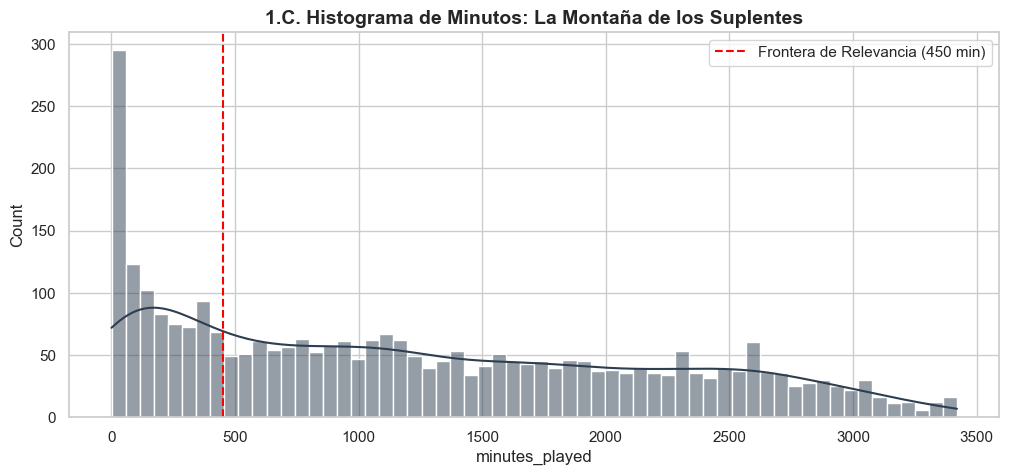

In [7]:
# Nota: Como hicimos fillna(0) en el ETL, buscamos "ceros excesivos" que podrían ser nulos disfrazados
print("\n--- A. Integridad de Datos ---")
nulos = df.isnull().sum().sum()
print(f"Total de valores Nulos (NaN) en la base: {nulos}")
print("(Si es 0, es porque el ETL hizo su trabajo rellenando con ceros)")

# B. Estadística Descriptiva Global
print("\n--- B. Resumen Estadístico Global (Top Variables) ---")
# Seleccionamos algunas clave para no saturar la pantalla
cols_desc = ['age', 'minutes_played', 'goals', 'assists', 'xg', 'tackles_total', 'saves']
print(df[cols_desc].describe().round(2))

# C. Distribución de Minutos (El Filtro Maestro)
plt.figure(figsize=(12, 5))
sns.histplot(df['minutes_played'], bins=60, kde=True, color='#2c3e50')
plt.axvline(450, color='red', linestyle='--', label='Frontera de Relevancia (450 min)')
plt.title('1.C. Histograma de Minutos: La Montaña de los Suplentes', fontsize=14, fontweight='bold')
plt.legend()
plt.show()


In [ ]:
# ==============================================================================
# PARTE 2: ANÁLISIS INTRA-GRUPAL (POR POSICIONES)
# ==============================================================================
print("\n" + "="*50)
print("2. ANÁLISIS INTRA-GRUPAL (SEGREGACIÓN POSICIONAL)")
print("="*50)

# Filtramos "ruido" para este análisis (Jugadores > 450 min)
df_core = df[df['minutes_played'] > 450].copy()
print(f"Analizando subconjunto de {len(df_core)} jugadores con > 450 minutos.")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Grupo Delanteros (FW) - Eficiencia
sns.boxplot(data=df_core, x='main_position_group', y='goals', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Distribución de GOLES por Posición')

# B. Grupo Creativos (MF) - Progresión
sns.boxplot(data=df_core, x='main_position_group', y='progressive_passes', ax=axes[0,1], palette='mako')
axes[0,1].set_title('Distribución de PASES PROGRESIVOS por Posición')

# C. Grupo Defensivo (DF) - Destrucción
sns.boxplot(data=df_core, x='main_position_group', y='tackles_total', ax=axes[1,0], palette='rocket')
axes[1,0].set_title('Distribución de TACKLES por Posición')

# D. Grupo Porteros (GK) - Trabajo
# Filtramos solo GK para que el gráfico no quede vacío en otras posiciones
df_gk = df_core[df_core['main_position_group'] == 'GK']
if not df_gk.empty:
    sns.violinplot(data=df_gk, y='saves', ax=axes[1,1], color='cyan')
    axes[1,1].set_title('Densidad de ATAJADAS (Solo Arqueros)')
else:
    axes[1,1].text(0.5, 0.5, 'Sin datos de GK suficientes', ha='center')

plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# PARTE 3: ANÁLISIS INTER-GRUPOS Y CONSISTENCIA (MICRO)
# ==============================================================================
print("\n" + "="*50)
print("3. ANÁLISIS DE CONSISTENCIA Y RELACIONES (CRUCE DE VARIABLES)")
print("="*50)

# A. Correlaciones Tácticas (Heatmap)
# ¿Se mueven juntas las métricas defensivas?
cols_def = ['tackles_total', 'interceptions', 'blocks', 'ball_recoveries', 'yellow_cards']
corr_mat = df_core[cols_def].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('3.A. Matriz de Coherencia Defensiva', fontsize=14, fontweight='bold')
plt.show()

# B. Scatter de Anomalías: Goles vs xG
# Buscamos "Overperformers" (Talento/Suerte) y "Underperformers" (Mala racha)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_core, x='xg', y='goals', hue='main_position_group', alpha=0.6, palette='deep')
# Línea de identidad
limit = max(df_core['goals'].max(), df_core['xg'].max())
plt.plot([0, limit], [0, limit], 'r--', alpha=0.5, label='Rendimiento Esperado')
plt.title('3.B. Consistencia Ofensiva: Realidad vs Expectativa', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

# C. Detección de Anomalías Específicas (El caso del "Portero Loco")
# Pregunta del usuario: ¿Hay porteros con muchas tarjetas amarillas?
print("\n--- 3.C. Detección de Anomalías: Porteros Indisciplinados ---")
gks_cards = df_core[df_core['main_position_group'] == 'GK'][['player_name', 'squad', 'yellow_cards']].sort_values('yellow_cards', ascending=False)
top_bad_boys = gks_cards.head(5)

if not top_bad_boys.empty:
    print("Top 5 Arqueros con más amarillas:")
    print(top_bad_boys)
    
    # Gráfico rápido si hay datos
    plt.figure(figsize=(8, 4))
    sns.barplot(data=top_bad_boys, x='yellow_cards', y='player_name', palette='Reds_r')
    plt.title('Anomalía: Arqueros con más Tarjetas Amarillas')
    plt.show()
else:
    print("No se encontraron arqueros con tarjetas en el corte seleccionado.")

print("\n" + "="*50)
print("✅ EDA FINALIZADO. DIAGNÓSTICO COMPLETO.")
print("="*50)